# Machine Learning - Classification & Probability Density Estimation
----

The **Classification** and **Probability Density Estimation (PDE)** tasks are introduced for a **Gaussian Mixture Model (GMM)**. For classification we motivate and implement **k-Nearest Neighbours** and **Radial Basis Functions** and for PDE, **Parzen Windows**. **Expectation Maximization** is introduced for fitting the GMM with **k Means Clustering** used to find the means. **Precision** and **Recall** are also introduced.

*Note: This notebook draws heavily from Abu-Mostafa et al. (2017, Chapter 6) which effectively documents the theory of this topic. It is highly recommended that a reader go through this resource. However, enough theory is given in this notebook for a firm grasp on the purpose served by code given below.*

This notebook introduces several different approaches for performing a classification task. The first two techniques for classification, [k-Nearest Neighbours](#k-Nearest-Neighbours) and [Radial Basis Function](#Radial-Basis-Function---Gaussian-Kernel) are not, strictly speaking, machine learning algorithms because there are no parameters that are learnt automatically by the system, but are nonetheless powerful in several circumstances.

## Data Generation and Visualization

Consider data drawn from the following four 2-dimensional gaussian distribtuion with probability density function of the form:

$$\normalsize
f(x) = \frac{1}{2\pi|\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}
$$

where $\Sigma$ is the covariance matrix and $\mu$ is the mean.

The following are the parameters for the distributions $a, b, c, d$: 

$$
\begin{bmatrix}\mu_a\\\mu_b\\\mu_c\\\mu_d\end{bmatrix} = \begin{bmatrix} 4.5 & 3.4 \\ 3 & 5.5\\ 4 & 7.5 \\ 2 & 3.5\end{bmatrix}\space
\Sigma_{a} = \begin{bmatrix} 1 &1.2\\1.2 &2\end{bmatrix}
\Sigma_{b} = \begin{bmatrix} 1 &-0.8\\-0.8 &1\end{bmatrix}
\Sigma_{c} = \begin{bmatrix} 0.5 &0\\0 &0.5\end{bmatrix}
\Sigma_{d} = \begin{bmatrix} 0.2 &0.1\\0.1 &0.2\end{bmatrix}
$$

We use 2-dimensional data as it makes for easy visualization but the methods introduced in this book can easily be extended to higher dimensions.

We draw 300 samples from each distribution i.e. 1200 samples - 1000 samples will be our labelled samples and will be used to determine the class membership of the other 200 samples.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

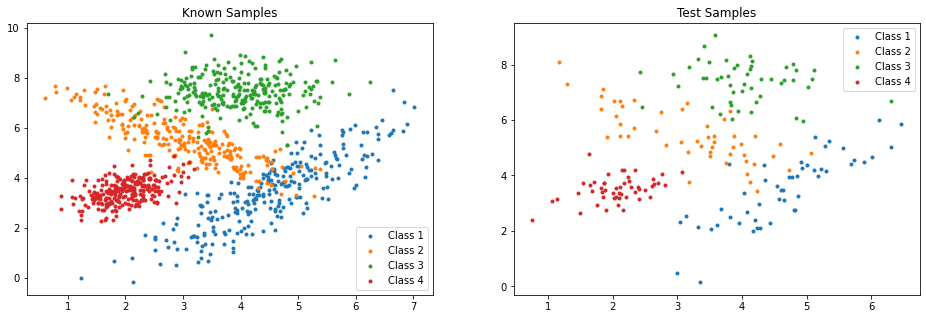

In [2]:
np.random.seed(159)

train_size = 250
test_size = 50
labels = np.ones(train_size + test_size)

means1 = np.array([4.5, 3.4])
covariance1 = np.array([[1, 1.2], [1.2, 2]])
all_samples1 = np.random.multivariate_normal(means1, covariance1, size=(train_size+test_size), check_valid='raise')
samples_and_labels1 = np.column_stack([all_samples1, labels])
samples1 = samples_and_labels1[:train_size]
test_samples1 = samples_and_labels1[train_size:]

means2 = np.array([3, 5.5])
covariance2 = np.array([[1, -0.8], [-0.8, 1]])
all_samples2 = np.random.multivariate_normal(means2, covariance2, size=(train_size+test_size), check_valid='raise')
samples_and_labels2 = np.column_stack([all_samples2, labels*2])
samples2 = samples_and_labels2[:train_size]
test_samples2 = samples_and_labels2[train_size:]

means3 = np.array([4, 7.5])
covariance3 = np.array([[0.5, 0], [0, 0.5]])
all_samples3 = np.random.multivariate_normal(means3, covariance3, size=(train_size+test_size), check_valid='raise')
samples_and_labels3 = np.column_stack([all_samples3, labels*3])
samples3 = samples_and_labels3[:train_size]
test_samples3 = samples_and_labels3[train_size:]

means4 = np.array([2, 3.5])
covariance4 = np.array([[0.2, 0.1], [0.1, 0.2]])
all_samples4 = np.random.multivariate_normal(means4, covariance4, size=(train_size+test_size), check_valid='raise')
samples_and_labels4 = np.column_stack([all_samples4, labels*4])
samples4 = samples_and_labels4[:train_size]
test_samples4 = samples_and_labels4[train_size:]

fig, axs = plt.subplots(1,2, figsize=(16,5))
axs[0].set_title('Known Samples')
axs[0].scatter(samples1[:, 0], samples1[:, 1], marker='.', label="Class 1");
axs[0].scatter(samples2[:, 0], samples2[:, 1], marker='.', label="Class 2");
axs[0].scatter(samples3[:, 0], samples3[:, 1], marker='.', label="Class 3");
axs[0].scatter(samples4[:, 0], samples4[:, 1], marker='.', label="Class 4");
axs[0].legend()

axs[1].set_title('Test Samples')
axs[1].scatter(test_samples1[:, 0], test_samples1[:, 1], marker='.', label="Class 1");
axs[1].scatter(test_samples2[:, 0], test_samples2[:, 1], marker='.', label="Class 2");
axs[1].scatter(test_samples3[:, 0], test_samples3[:, 1], marker='.', label="Class 3");
axs[1].scatter(test_samples4[:, 0], test_samples4[:, 1], marker='.', label="Class 4");
axs[1].legend()

#Join all the data together with the respective labels
known_samples = np.vstack([samples1, samples2, samples3, samples4])
test_samples = np.vstack([test_samples1, test_samples2, test_samples3, test_samples4])

## Evaluation

Before the actual classification of data points, some evaluation metrics are set up to determine the performance of classification methods. 

The primary metric that we will use will be the **Balanced Accuracy** which is the average of **recall** for each class.

We will also use a confusion matrix which will give both the **precision** and **recall** for each class. As a reminder, precision and recall are defined as:

$$
\begin{split}
\text{precision} &= \frac{\text{True Positives}}{\text{True Positives + False Positives}}\\\\
\text{recall} &= \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{split}
$$

In [3]:
'''
Given a true class membership and classification, 
returns the balanced accuracy score.
If show_precision_recall is set to True, returns a
tabular representation of precision and recall for
each class.

If show_confusion_matrix is set to True, plots the
confusion matrix on axis cm_axis (if provided) else
on a default axis
'''
def evaluate(true_class, classification, show_precision_recall=False, show_confusion_matrix=False, cm_axis=None):
    cm = confusion_matrix(true_class, classification)
    true_positive = np.diag(cm)
    tp_fp = np.sum(cm, 0)
    positives = np.sum(cm, 1)
    precision = np.divide(true_positive, tp_fp)
    recall = np.divide(true_positive, positives)
    pr_df = pd.DataFrame({'Precision': precision, 'Recall': recall})
    if(show_precision_recall):
        display(pr_df)
    if(show_confusion_matrix):
        ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4]).plot(cmap='cividis', ax=cm_axis)
    #Return the Balanced Accuracy Score
    return(np.mean(recall))

'''
Given the data points, their true class membership
and classification, plots the points on provided axes
with each class represented by a colour indexed from
the colours argument. Errors are marked with an 'x'.
'''
def show_classification_with_error(test_samples, true_class, classification, ax=None, colours=None):
    correct_classification = true_class==classification
    classes = np.unique(classification)
    if(not ax):
        fig, ax = plt.subplots(1,1)
    if(not colours):
        colours = np.array(['white', 'C0', 'C1', 'C2', 'C3'])
        
    #print(true_class)
    #print(classification)
        
    ax.scatter(test_samples[correct_classification][:,0], test_samples[correct_classification][:,1], marker='.', c=colours[classification[correct_classification].astype(int)])
    ax.scatter(test_samples[~correct_classification][:,0], test_samples[~correct_classification][:,1], marker='x', label="Incorrect Classification", c='black')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.legend()

## k-Nearest Neighbours

We begin with the simple k-nearest neighbours approach i.e. for every point we find the class of the $k$ nearest neighbours and assign this class to the point as below:

Let $x_{an} = \begin{bmatrix}x_{an_1}, x_{an_2}, \dots, x_{an_k} \end{bmatrix}$ be the $k$ nearest neighbours to point $x_a$ in the labelled dataset. Then our classification for point $x_a$ i.e. $g(x_a)$ is:

$$
g(x_a) = \max{\text{class}(x_{an})}
$$

where $\text{class}(x_{an})$ is the known true class of each $x_{an_i} \in x_{an}$ with ties broken arbitrarily.

We implement this algorithm below for demonstration purposes but use a more efficient sklearn implementation for evaluation. We will use 5 fold cross-validation to determine the ideal value of $k$.

In [4]:
#Get distances from every point in known to every point in unknown
def get_distances(known, unknown):
    r = np.linalg.norm(known - unknown[:, np.newaxis], axis=2);
    return r;

def knn(known, unknown, k):
    r = get_distances(known[:, :2], unknown[:,:2])
    knn_indices = np.argsort(r, axis=1)[:, :k]
    knn = np.take_along_axis(known[:, 2, np.newaxis], knn_indices, axis=0)
    classification = stats.mode(knn, axis=1).mode
    return classification.ravel()

In [5]:
#Set Number of folds
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=317)

balanced_accuracy_score = []
for k in range(1,101):
    single_fold_score = []
    for train, test in kf.split(known_samples):
        classification = knn(known_samples[train], known_samples[test], k)
        score = evaluate(known_samples[test,2], classification)
        single_fold_score.append(score)
    average_score = np.mean(single_fold_score)
    balanced_accuracy_score.append(average_score)

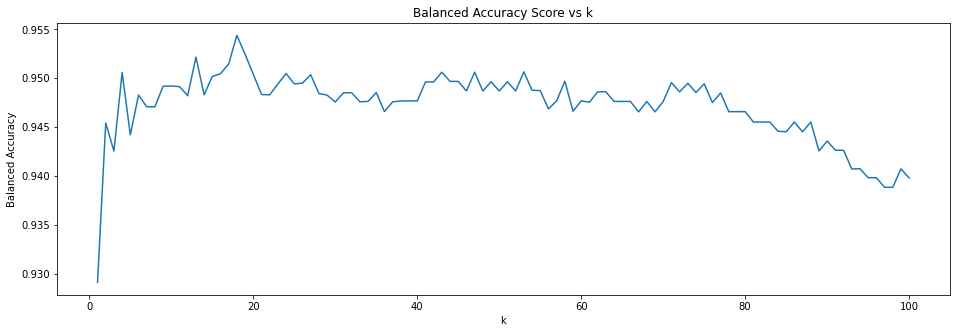

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.set_title("Balanced Accuracy Score vs k")
ax.set_xlabel("k")
ax.set_ylabel("Balanced Accuracy")
plt.plot(np.arange(1,101), balanced_accuracy_score);

From above, we see that the ideal value is at around $k=20$ and set $k=17$. We now use this value of $k$ to classify our test points.

,Precision,Recall
0,0.907407,0.98
1,0.934783,0.86
2,0.959184,0.94
3,0.980392,1.00



Balanced Accuracy Score (Average Recall) is: 0.945


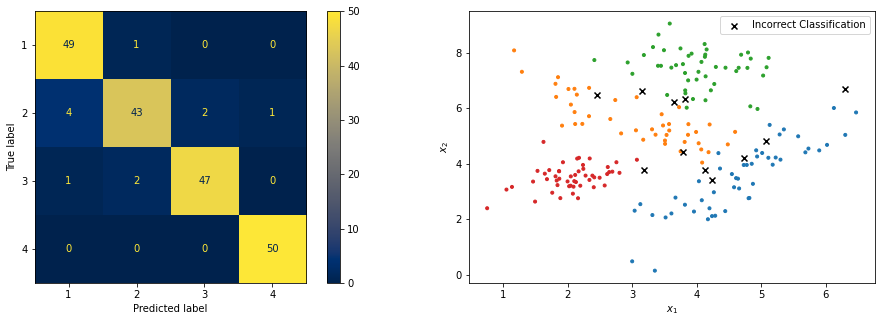

In [7]:
classification = knn(known_samples, test_samples, 17)
fig, axs = plt.subplots(1,2, figsize=(16,5))
score = evaluate(test_samples[:, 2], classification, True, True, axs[0])
print("\nBalanced Accuracy Score (Average Recall) is:", score)
show_classification_with_error(test_samples, test_samples[:, 2], classification, ax=axs[1])

We thus see that the class with the lowest recall i.e. most true members classified as belonging to another class is class 2 and that with the lowest precision i.e. most classified members not truly belonging to this class is class 1. 

## Radial Basis Function - Gaussian Kernel

Using the k-nearest neighbours method, we have effectively been allowing $k$ nearest neighbours equal say in the determination of the class of an unknown point. Perhaps there is a benefit to be gained by giving points closer to our unknown point a greater say in the membership of its class? This is the essence of radial basisc functions (or kernels) explored below.

We aim to place a gaussian kernel (of the form $\normalsize\phi(z) = e^{-\frac{1}{2}z^2}$) at every test x whose class we want to determine. The strength of the gaussian at each known sample will determine the weight that this sample's label will have in determining our classification. Because our data is not ordinal (i.e. the classes have no inherent order) we will adopt a one-vs-all approach to classification.

This translates to a weighted average of all the known samples' labels, with weights given by $$\frac{\alpha_n(x)}{\sum_{m=1}^N\alpha_m(x)} $$ where $$\alpha_n(x) = \phi\left(\frac{\| x - x_n \|}{r}\right)$$

where $r$ is a factor that determines the 'radial' influence of the kernel - we shall set $r$ to 0.5 initially and see the results.

Let us first visualize what this kernel would look like when placed at a random point initially.

In [8]:
def gaussian_kernel(data, dimension=1, normalised=False):
    data_sq = data**2
    kernel_applied = np.exp(-0.5*data_sq)
    if normalised:
        normalisation_factor = (2*(np.pi))**(dimension/2)
        return_value = kernel_applied/normalisation_factor
    else:
        return_value = kernel_applied
    return return_value

'''
Given two dataset, data_a(nxd) and data_b(kxd) places a 
gaussian kernel at each point in data_b and the value at 
each point in data_b (scaled by a factor r) determines the 
influence (weights) of the point in data_b on the point in
data_a.

If normalised is True, then ensures that the intgeral across
all absolute values for the distance of the gaussian kernel 
evaluates to 1.
'''
def rbf_gaussian_kernel(data_a, data_b, r, normalised=False):
    dimension = data_a.shape[1]
    norm = np.linalg.norm(data_b - data_a[:, np.newaxis], axis=2)
    scaled_distance = norm/r
    kernel_applied = gaussian_kernel(scaled_distance, dimension, normalised)
    return kernel_applied

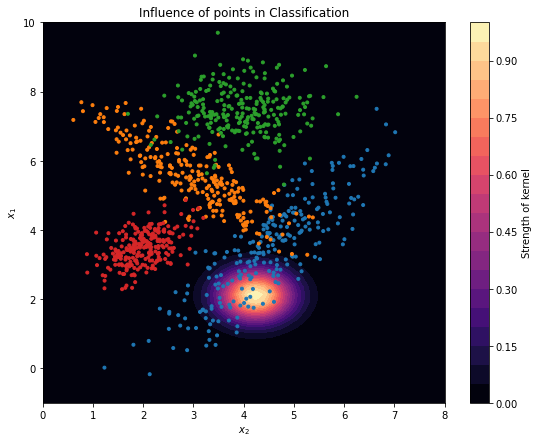

In [9]:
x = np.linspace(0,8,50)
y = np.linspace(-1,10,50)
X,Y = np.meshgrid(x,y)
zipped = np.column_stack([X.flatten(), Y.flatten()])
sample_to_classify = test_samples[0, :2][np.newaxis, :]

r=0.5
kernel_applied = rbf_gaussian_kernel(sample_to_classify, zipped,r)
fig, ax = plt.subplots(1,1, figsize=(9,7))
cset = ax.contourf(X,Y,kernel_applied.reshape(X.shape), levels=20, cmap='magma')
colours = np.array(['white', 'C0', 'C1', 'C2', 'C3'])
ax.scatter(known_samples[:,0], known_samples[:,1], marker='.', c=colours[known_samples[:,2].astype(int)])
cbar = fig.colorbar(cset, ax=ax);

ax.set_ylabel("$x_1$")
ax.set_xlabel("$x_2$")
cbar.ax.set_ylabel("Strength of kernel")
ax.set_title("Influence of points in Classification");

We thus see that the radial basis function (kernel) gives  points around it a greater weight (importance) in the determination of its class. We repeat this for every point that we wish to classify.

In [10]:
def rbf_neighbours(known_samples, test_samples, r):
    '''Generate the weight of each existing datapoint for each point to be classified'''
    kernel_weights = rbf_gaussian_kernel(test_samples[:,:2], known_samples[:, :2],r)
    kernel_weights_normalised = kernel_weights/np.sum(kernel_weights, axis=1)[:, np.newaxis]
    
    '''Perform 1 vs all Classification'''
    memberships = np.empty((4, test_samples.shape[0]))
    for i in range(1,5):
        memberships[i-1] = np.matmul(kernel_weights_normalised, known_samples[:,2]==i)
    #Adjusting for non-zero indexed classes
    classification = np.argmax(memberships, axis=0)+1
    return classification

We will adopt a 5 fold cross-validation approach as before to find parameter $r$.

In [11]:
#Set Number of folds
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=317)

balanced_accuracy_score = []
range_of_r = np.linspace(0.1, 1.2, 30)
for r in range_of_r:
    single_fold_score = []
    for train, test in kf.split(known_samples):
        classification = rbf_neighbours(known_samples[train], known_samples[test], r)
        score = evaluate(known_samples[test,2], classification)
        single_fold_score.append(score)
    average_score = np.mean(single_fold_score)
    balanced_accuracy_score.append(average_score)

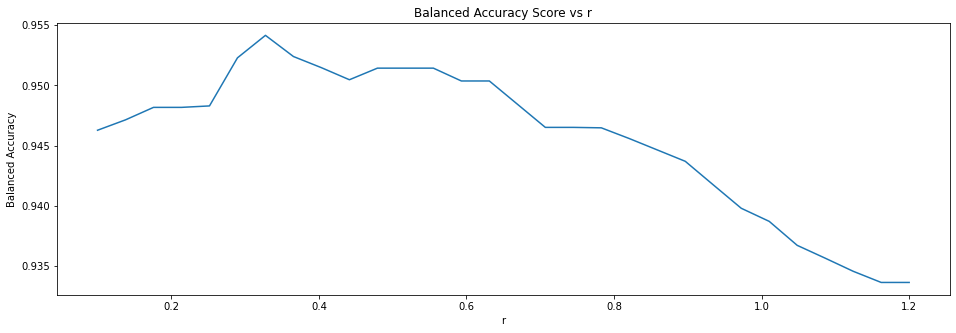

In [12]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.set_title("Balanced Accuracy Score vs r")
ax.set_xlabel("r")
ax.set_ylabel("Balanced Accuracy")
plt.plot(range_of_r, balanced_accuracy_score);

From above, we see that the ideal value of $r$ is around $r=0.3$ and set $r=0.33$. We now use this value of $r$ to classify our test points.

,Precision,Recall
0,0.905660,0.96
1,0.895833,0.86
2,0.958333,0.92
3,0.980392,1.00



Balanced Accuracy Score (Average Recall) is: 0.9349999999999999


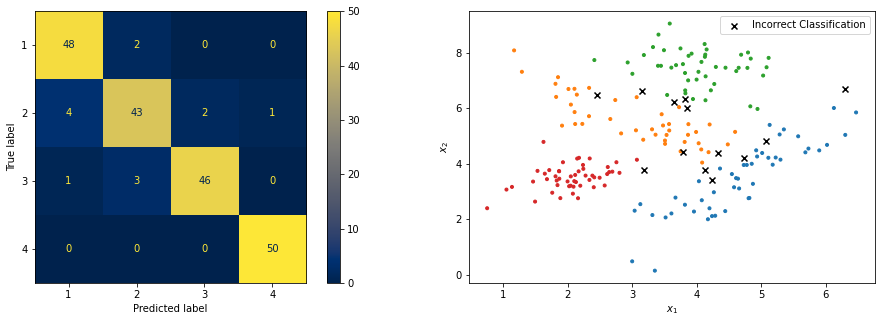

In [13]:
r=0.33
classification = rbf_neighbours(known_samples, test_samples, r)
fig, axs = plt.subplots(1,2, figsize=(16,5))
score = evaluate(test_samples[:, 2], classification, True, True, axs[0])
print("\nBalanced Accuracy Score (Average Recall) is:", score)
show_classification_with_error(test_samples, test_samples[:, 2], classification, ax=axs[1])

Thus we end up performing slightly worse than with the simple k-nearest neighbours approach. The advantage of the k-nearest neighbour approach over the radial basis function method can be seen in the fact that outlier points are influenced by the full $k$ nearest neighbours which is not the case in the latter approach.

So far we have relied on the similarity of neighbouring points while classifying new points. We have not tried to determine the true underlying distribution for each class. We now introduce this in the following section.

## Probability Density Estimation

We begin our introduction of probability density estimation by considering the 1-dimensional case. We draw 10 samples from a uniform distribution with probability density function $f(x)$ given as:
$$
f(x) = \begin{Bmatrix} x \text{ where }x\in [0,1]\\ 0\space \text{otherwise}\end{Bmatrix}
$$

Using these 10 points, we try to determine the probability density. The probability density approaches are analogous to the classification approaches given earlier i.e. we use a k-Nearest Neighbour Density Estimation and a Parzen Window (Gaussian Kernel Density Estimation) approach. The difference is that here we are estimating an underlying true probability density function.

### k-Nearest Neighbour Density Estimation

As suggested by the name, k-Nearest Neighbours relies on the distance to the k-nearest neighbour to determine the density. For the 1 dimensional case, this is fairly straightforward. Let $r$ be the distance from a point $x$ to it's $k$ nearest neighbour from the dataset for which we want to estimate the pdf. The 1 dimensional spheroid centered at point $x$ with radius $r$ is simply the line $[x-r, x+r]$. The volume of this line is thus $2r$ and the density of the distribution within this spheroid centered at $x$ is $\frac{k}{2r}$. We thus choose our pdf $f(x)$ as:
$$
f(x) = c \cdot \frac{k}{2r}
$$

where $c$ is chosen as a regularization constant such that $\int f(x) dx = 1$ 

### Parzen Window

The Parzen Window is a Radial Basis Function approach for Density Estimation. Consider, instead of a spheroid centered at $x$, a Gaussian kernel placed at $x$ decaying away from this point. Rather than consider every point within a spheroid equally, as we were doing in the nearest neighbour approach, we instead weight each neighbour by the value the Gaussian kernel takes at a given point i.e. closer points contribute more than points further away. However, since there are a fixed number of 'neighbours', this leads to an awkward normalization mechanism for each pdf to sum to 1.

Alternatively, consider placing a gaussian kernel centered at each known sample drawn from the distribution. The value of this kernel at any $x$ is equal to the value of a kernel centered at the corresponding known sample at $x$. Since the Gaussian kernel itself can be normalized to give a pdf, we thus simply sum all these kernels and scale by the number of samples. Thus the pdf $f(x)$ at any point $x$ is:

$$
f(x) = \frac{1}{Nr^d}\sum_{i=0}^{N-1}\phi\bigg(\frac{\|x-x_i\|}{r}\bigg)
$$

where $x_i$ is a known sample, $\phi(z)$ (for the one dimensonal case) is the normalized Gaussian kernel:

$$
\phi{(z)} = \frac{1}{\sqrt{(2\pi)}}e^{-\frac{1}{2}z^2}
$$

This is know as a Parzen window.

Below we show illustrations of the estimated pdfs for the $10$ samples drawn previously from a uniform distribution.

In [14]:
def dist_k_nearest_neighbour(xs, rv, k):
    distances = np.linalg.norm(xs-rv[:, np.newaxis], axis=2).T
    sorted_d = np.sort(distances, axis=1)
    return sorted_d[:, k]

def knn_density(xs, rv, k):
    k_dist = dist_k_nearest_neighbour(xs, rv, k)
    p_x = k/(2*k_dist)
    c = sum(p_x)
    p_x_norm = p_x/c
    return p_x_norm

In [15]:
def parzen_window(xs, rv, r):
    dimension = xs.shape[1]
    applied_kernel = rbf_gaussian_kernel(xs, rv, r, True)
    sum_per_x = np.sum(applied_kernel, axis=1)
    normalisation = rv.shape[0]*(r**dimension)
    parzen = sum_per_x/normalisation
    #additional normalization factor for number of xs
    parzen = parzen/np.sum(parzen)
    return parzen

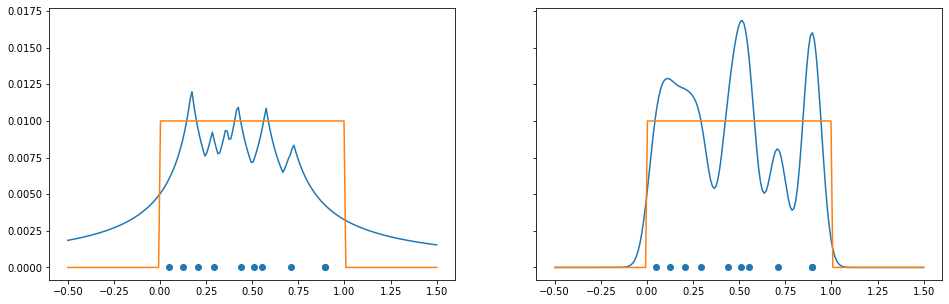

In [16]:
np.random.seed(3)
'''Demonstration in 1 Dimension'''
number_of_samples = 10

urv = np.random.uniform(size = number_of_samples)[:, np.newaxis]
xs = np.linspace(-0.5,1.5,200)[:, np.newaxis]

'''K Nearest Neighbour'''
k = 3
knn_px = knn_density(xs, urv, k)

'''Parzen Window with Gaussian Kernel'''
r = 0.05
parzen_px = parzen_window(xs, urv, r)

fig, axs = plt.subplots(1,2, figsize=(16,5), sharey = True)

axs[0].plot(xs.ravel(), knn_px)
axs[0].scatter(urv.ravel(), np.zeros(number_of_samples))
axs[0].plot(xs.ravel(), np.hstack((np.zeros(50), np.ones(100)/100, np.zeros(50))));

axs[1].plot(xs.ravel(), parzen_px)
axs[1].scatter(urv.ravel(), np.zeros(number_of_samples))
axs[1].plot(xs.ravel(), np.hstack((np.zeros(50), np.ones(100)/100, np.zeros(50))));

We note that the major differences in the two probability density estimation approaches are that the gaussian kernel produces smoother results and decays much faster outside the true pdf than the k-nearest neighbours approach. The latter is fat-tailed.

Returning to our previous 2 dimensional four class data, we assume that all data was generated from a single probability distribution and perform a 2-dimensional estimation of this probability distribution.

In [17]:
#Equivalent to scipy.stats.multivariate_normal
def multivariate_normal_pdf(mu, covariance, x):
    inv_cov = np.linalg.inv(covariance)
    x_minus_mu = x-mu
    '''TODO: Note that this implementation is wasteful as we only need the diagonal'''
    mahalanobis = np.matmul(x_minus_mu, np.matmul(inv_cov, x_minus_mu.T)).diagonal()
    exp = np.exp(-0.5*mahalanobis)
    normalisation_factor = ((2*np.pi)**(mu.shape[0]/2)) * (np.linalg.det(covariance)**(1/2))
    pdf = exp/normalisation_factor
    return pdf

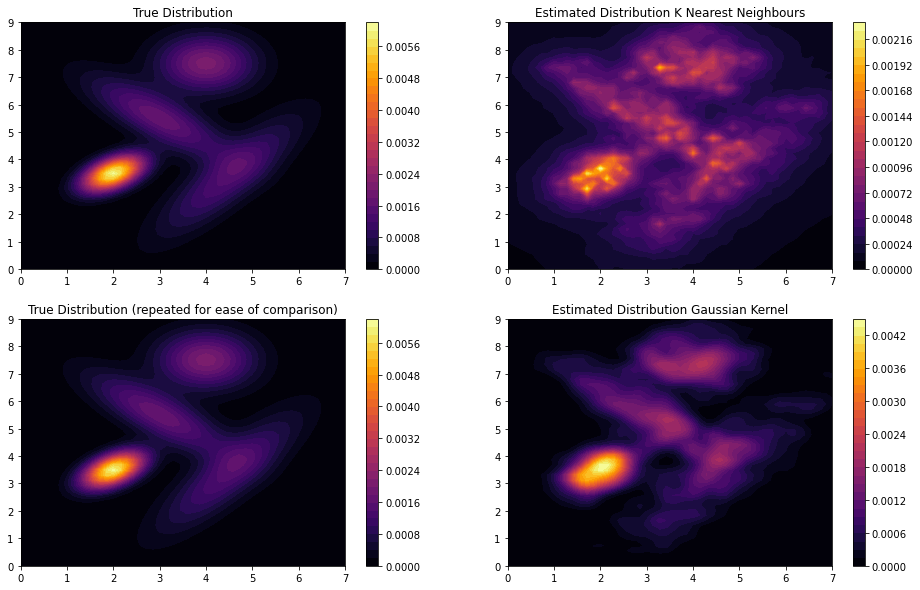

In [18]:
'''Returning to our previous data'''
x = np.linspace(0,7,50)
y = np.linspace(0,9,50)
X,Y = np.meshgrid(x,y)
zipped = np.column_stack([X.flatten(), Y.flatten()])

'''k Nearesh Neighbour Density Estimation'''
k = 5
knn_px = knn_density(zipped, known_samples[:,:2], k)

r = 0.19
parzen_px = parzen_window(zipped, known_samples[:,:2], r)

'''Calculate the True PDF'''
pdf1 = multivariate_normal_pdf(means1, covariance1, zipped)
pdf2 = multivariate_normal_pdf(means2, covariance2, zipped)
pdf3 = multivariate_normal_pdf(means3, covariance3, zipped)
pdf4 = multivariate_normal_pdf(means4, covariance4, zipped)
total_true_pdf = (pdf1+pdf2+pdf3+pdf4)/4
total_true_pdf_norm = total_true_pdf/np.sum(total_true_pdf)

fig, axs = plt.subplots(2,2, figsize=(16, 10))

axs[0,0].set_title("True Distribution")
cset2 = axs[0,0].contourf(X,Y, total_true_pdf_norm.reshape(X.shape), levels=30, cmap='inferno')
fig.colorbar(cset2, ax=axs[0,0]);

axs[0,1].set_title("Estimated Distribution K Nearest Neighbours")
cset1 = axs[0,1].contourf(X, Y, knn_px.reshape(X.shape), levels = 30, cmap='inferno')
fig.colorbar(cset1, ax=axs[0,1]);

axs[1,0].set_title("True Distribution (repeated for ease of comparison)")
cset2 = axs[1,0].contourf(X,Y, total_true_pdf_norm.reshape(X.shape), levels=30, cmap='inferno')
fig.colorbar(cset2, ax=axs[1,0]);

axs[1,1].set_title("Estimated Distribution Gaussian Kernel")
cset2 = axs[1,1].contourf(X,Y, parzen_px.reshape(X.shape), levels=30, cmap='inferno')
fig.colorbar(cset2, ax=axs[1,1]);

## Fitting a Gaussian Mixture Model

We now reach the final section of this notebook that we have been building towards. We have seen how to place a gaussian kernel at each known sample in order to estimate the underlying probability distribution via the pdf. However, we know that the true pdf is actually four skewed Gaussian kernels placed at specific points i.e. a Gaussian Mixture Model. We now move to determine these four kernels from known samples and assign membership based on proximity to each of these kernels.

In the last section we placed a Gaussian kernel at each of the samples. If instead we had a mechanism for determining the four centers of each of the underlying distributions, we could place a kernel at each of these centers. We would further be able to assign class membership based on proximity to each of these kernels.

### k Means Clustering

This extremely simple algorithm provides a mechanism for determining the $k$ means in a dataset such that the distance (here $\mathcal{L}_1$ norm to all points is minimised. It is a very simple algorithm comprising three steps:

1. Initialize the first center by picking any arbitrary datapoint. Pick the next center by choosing the point furthest away from the the centers chosen so far$^1$ and repeat till $k$ centers are found.
2. For every point in the dataset, assign membership based on proximity to a chosen center, i.e. the closest center is the parent center.
3. For each of these 'clusters' find the mean and update the center. Repeat steps 2-3 till some stopping criteria is met eg. no change in centers.

$^1$ The distance of a point from a set of points is here defined to be its distance from the nearest point in the set

In [19]:
'''
Initialize K centers for a given dataset x using
the above approach
'''
def k_means_initialize(x, k):
    distances_to_centers = np.empty((x.shape[0], k))
    centers = np.empty((k, x.shape[1]))
    center = x[0]
    i = 0
    while(i<k):
        centers[i, :] = center
        distance_to_center = get_distances(x, center[np.newaxis,:]).T
        #Keep track of distances to each center
        distances_to_centers[:,i] = distance_to_center.ravel()
        #Find the closest point to each center
        closest_each_center = np.argmin(distances_to_centers[:,:i+1],axis=1)[:, np.newaxis]
        #Select the furthest point from among the closest points to each center
        center = x[np.argmax(np.take_along_axis(distances_to_centers, closest_each_center, axis=1))]
        i = i+1
    return centers

'''
Perform the k-Means clustering algorithm on a dataset
x where each row is a separate sample. Use K as the 
k 'number of clusters'.

Returns the cluster centers
'''
def k_means(x,k):
    #Initialize centers with greedy approach
    centers = k_means_initialize(x,k)
    distances = get_distances(x, centers).T
    loss = np.sum(np.amin(distances, axis=1))
    while(True):
        membership = np.argmin(distances, axis=1)
        for cluster in range(k):
            #Find which samples are in the current cluster
            cluster_components = x[membership == cluster]
            cluster_size = cluster_components.shape[0]
            cluster_sum = np.sum(cluster_components, 0)
            #Update the center based on the cluster centroid
            centers[cluster, :] = cluster_sum/cluster_size
        distances = get_distances(x, centers).T
        new_loss = np.sum(np.amin(distances, axis=1))
        if(new_loss == loss ):
            break
        else:
            loss = new_loss
    return centers

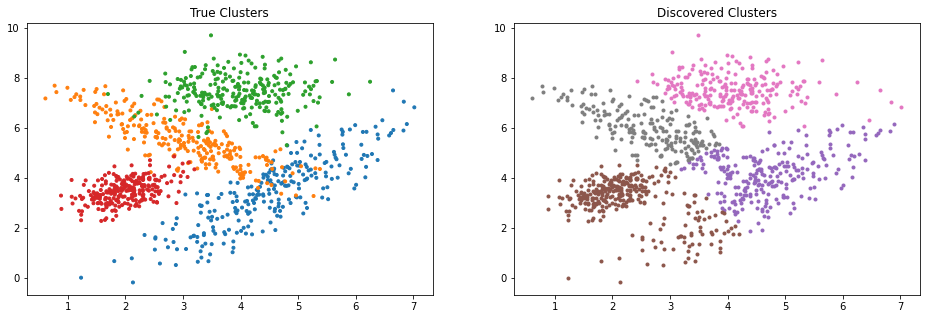

In [20]:
centers = k_means(known_samples[:, :2], 4)
distances = get_distances(known_samples[:,:2], centers).T
membership = np.argmin(distances, axis=1)+1

fig, axs = plt.subplots(1, 2, figsize=(16,5))

colours = np.array(['white', 'C0', 'C1', 'C2', 'C3'])
colours_other = np.array(['white', 'C4', 'C5', 'C6', 'C7'])

axs[0].set_title("True Clusters")
axs[0].scatter(known_samples[:, 0], 
               known_samples[:, 1], 
               marker='.', c=colours[known_samples[:, 2].astype(int)])

axs[1].set_title("Discovered Clusters")
for cluster in range(1,5):
    axs[1].scatter(known_samples[:, 0][membership == cluster], 
                   known_samples[:, 1][membership==cluster], 
                   marker='.', color=colours_other[cluster])

It is clear, looking at the data, that the standard Guassian kernel that we have been discussing so far will not accurately represent each class because of the highly skewed nature of two of the underlying distributions. We thus need a way to take this into account as well. This can be easily done by allowing our 2-dimensional Gaussian kernel to take the form:

$$\normalsize
\phi(z) = \frac{1}{2\pi|\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(z-\mu)^T\Sigma^{-1}(z-\mu)}
$$

where we must find the values for the covariance matrix $\Sigma$ and the means $\mu$.

### Maximum Likelihood

From the notebook on [Maximum Likelihood](Maximum%20Likelihood%20-%20Theory.ipynb) we have an effective method of determining a single model from within a class of models that represents some data. The class of models that we will consider is the weighted sum of four gaussian kernels given above (for which the weights must be determined) and the single model will thus specify these weights, the means and the covariance matrix for each of these four kernels.

We represent the probability of $x \in \phi_j$ i.e. the sample $x$ is drawn from distribution $j$ as:

$$
\mathbb{P}[j] = w_j
$$

for $j = [1,2,3,4]$

We further know from the form of each kernel that

$$
f(x|j) = \frac{1}{2\pi|\Sigma_j|^{\frac{1}{2}}}e^{-\frac{1}{2}(z-\mu_j)^T\Sigma_j^{-1}(z-\mu_j)}
$$

Thus, the pdf is:

$$
\begin{split}
f(x) &= \sum_{j=1}^{4}f(x|j)\mathbb{P}(j)\\
&= \sum_{j=1}^{4}\frac{w_j}{2\pi|\Sigma_j|^{\frac{1}{2}}}e^{-\frac{1}{2}(z-\mu_j)^T\Sigma_j^{-1}(z-\mu_j)}
\end{split}
$$

For any pdf $f_i(x)$ we have the probability of all observed samples being drawn from this distrubtion as $f_i(x_1, x_2, \dots, x_n)$. Maximising this value we find:

$$
\begin{split}
\underset{\mu,\Sigma,w}{\text{argmax}} f_i(x_1, x_2, \dots, x_n) &= \underset{\mu,\Sigma,w}{\text{argmax}} \prod_{n=1}^{N}f_i(x_n)\\
&= \underset{\mu,\Sigma,w}{\text{argmax}}\sum_{n=1}^{N}\ln{f_i(x_n)}\\
&= \underset{\mu,\Sigma,w}{\text{argmax}}\sum_{n=1}^{N}\ln{\sum_{j=1}^{4}\frac{w_j}{2\pi|\Sigma_j|^{\frac{1}{2}}}e^{-\frac{1}{2}(z-\mu_j)^T\Sigma_j^{-1}(z-\mu_j)}}
\end{split}
$$

Due to the summation inside the $\ln$ function maximizing this is not trivial. We thus introduce the Expectation Maximization algorithm to solve this problem.

*Note: Further explanations and motivations for this can be found [here](Maximum%20Likelihood%20-%20Theory.ipynb).*

### Expectation Maximization

The expectation maximization algorithm works as follows:
1. Find a critical piece of information that poses a barrier to evaluation
2. Estimate this critical piece of information
3. Based on this estimate, determine all other parameters of the model
4. With these parameters, update the estimate and repeat till some stopping criteria (eg. convergence)

In this Gaussian Mixture Model case, the critical piece of information is the true distribution, from among the four we are considering, to which each of the drawn samples belongs. These need not be absolute i.e. a sample may belong in part to one distribution and in part to another (for the purposes of the algorithm, not in practice).

We then find that we first estimate distribution memberships. For each distribution, then, the number of points belonging to it are:

$$
N_j = \sum_{n=1}^{N}\gamma_{nj}
$$

where $\gamma_{nj}$ is the 'amount' or 'ratio' of the point $n$ that belongs to the distribution $j$. We then find the following values for each of the other parameters:

$$
\begin{split}
w_j &= \frac{N_j}{N}\\
\mu_j &= \frac{1}{N_j}\sum_{n=1}^N \gamma_{nj}x_n\\
\Sigma_j &= \frac{1}{N_j}\sum_{n=1}^N \gamma_{nj}\|x_n\|^2 - \|\mu_j\|^2
\end{split}
$$

We then update the memberships of each distribution (class) as:

$$
\begin{split}
\gamma_{nj} \leftarrow \mathbb{P}[j|x_n] &= \frac{f(x_n|j)\mathbb{P}[j]}{f(x_n)}\\
&= \frac{w_j \phi_j(x_n)}{\sum_{m=1}^4 w_m \phi_m(x_n)}
\end{split}
$$

Below we implement this algorithm and also show the output from application of scikit-learn's implementation.

In [21]:
def fit_gaussian_model(data, k=4):
    samples_count = data.shape[0]
    initial_centers = k_means(data[:,:2], k)
    gamma = np.zeros((samples_count, k))
    covariances = np.zeros((k, 2, 2))
    mvn = np.zeros((samples_count, k))
    means = np.zeros((k ,2))
    weights = np.zeros(k)
    distances = get_distances(data[:,:2], initial_centers).T
    memberships = np.argmin(distances, axis=1)
    np.put_along_axis(gamma, memberships[:, np.newaxis], 1, axis=1)

    for i in range(1000):
        membership_count = np.sum(gamma, axis=0)
        weights = membership_count/samples_count
        weighted_centers = np.matmul(gamma.T, data[:, :2])
        means = weighted_centers/membership_count[:, np.newaxis]
        for j in range(k):
            running_sum = np.zeros((2,2))
            for n in range(samples_count):
                x_sq = np.matmul(data[n,:2][:,np.newaxis], data[n,:2][np.newaxis, :])
                running_sum = running_sum + gamma[n, j]*x_sq
            scaled_sum = running_sum/membership_count[j]
            means_sq = np.matmul(means[j][:, np.newaxis], means[j][np.newaxis, :])
            covariances[j] = scaled_sum - means_sq
            mvn[:, j] = weights[j]*multivariate_normal_pdf(means[j], covariances[j], data[:, :2])
        denom_sum = np.sum(mvn, axis=1)[:, np.newaxis]
        gamma = mvn/denom_sum
        
    return (weights, means, covariances, gamma)

In [22]:
'''using the above gmm imlementation'''
(weights_local, means_local, covariances_local, gamma_local) = fit_gaussian_model(known_samples[:, :2], 4)

pdf1 = multivariate_normal_pdf(means_local[0], covariances_local[0], zipped)
pdf2 = multivariate_normal_pdf(means_local[1], covariances_local[1], zipped)
pdf3 = multivariate_normal_pdf(means_local[2], covariances_local[2], zipped)
pdf4 = multivariate_normal_pdf(means_local[3], covariances_local[3], zipped)
total_pdf = (pdf1*weights_local[0]+pdf2*weights_local[1]+pdf3*weights_local[2]+pdf4*weights_local[3])/4
total_pdf_norm = total_pdf/np.sum(total_pdf)

memberships_local = np.argmax(gamma_local, axis=1)

'''
scikit-learn implementation:
Given below for reference. We don't plot the results in the interest
of space because they turn out to be exactly the same as that for our
own implementation.
'''
gm = GaussianMixture(n_components=4).fit(known_samples[:,:2])
weights_sk = gm.weights_
means_sk = gm.means_
covariances_sk = gm.covariances_

pdf1_sk = multivariate_normal_pdf(means_sk[0], covariances_sk[0], zipped)
pdf2_sk = multivariate_normal_pdf(means_sk[1], covariances_sk[1], zipped)
pdf3_sk = multivariate_normal_pdf(means_sk[2], covariances_sk[2], zipped)
pdf4_sk = multivariate_normal_pdf(means_sk[3], covariances_sk[3], zipped)
total_pdf_sk = (pdf1_sk*weights_sk[0]+pdf2_sk*weights_sk[1]+pdf3_sk*weights_sk[2]+pdf4_sk*weights_sk[3])
total_pdf_norm_sk = total_pdf_sk/sum(total_pdf_sk)
labels_sk = gm.predict(known_samples[:,:2])

,Precision,Recall
0,0.888889,0.96
1,0.931818,0.82
2,0.941176,0.96
3,0.980392,1.00



Balanced Accuracy Score (Average Recall) is: 0.9349999999999999


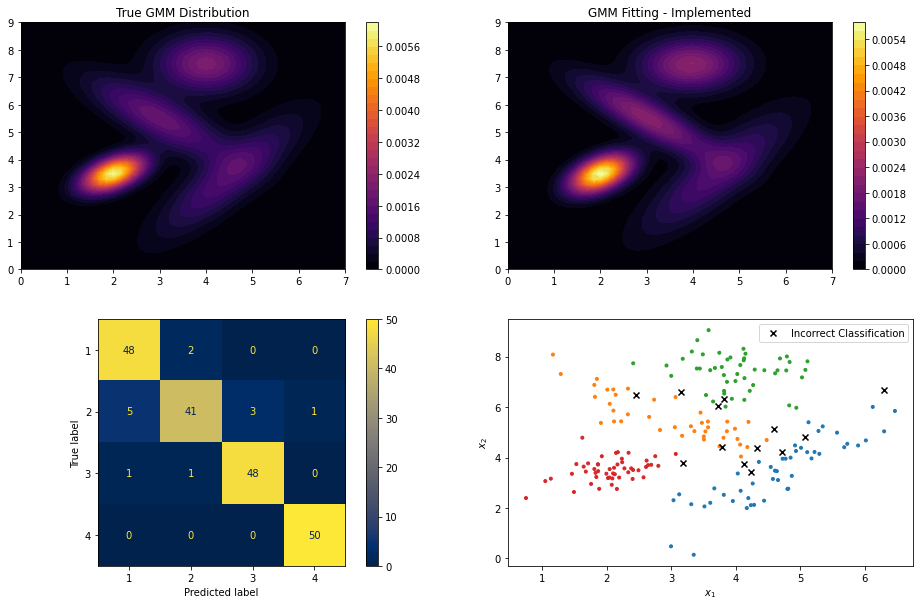

In [23]:
#classify test samples
prob_1 = multivariate_normal_pdf(means_local[0], covariances_local[0], test_samples[:,:2])
prob_2 = multivariate_normal_pdf(means_local[1], covariances_local[1], test_samples[:,:2])
prob_3 = multivariate_normal_pdf(means_local[2], covariances_local[2], test_samples[:,:2])
prob_4 = multivariate_normal_pdf(means_local[3], covariances_local[3], test_samples[:,:2])
all_classes = np.column_stack([prob_1, prob_2, prob_3, prob_4])
assigned_class = np.argmax(all_classes, axis=1)

#simple heuristic to ensure class names match true class labels
for c in range(1, 5):
    c_indices = test_samples[:,2]==c
    mapped_class = stats.mode(assigned_class[c_indices]).mode
    assigned_class[assigned_class==mapped_class] = c+4   
assigned_class = assigned_class-4

fig, axs = plt.subplots(2,2, figsize=(16,10))

axs[0,0].set_title("True GMM Distribution")
cset0 = axs[0,0].contourf(X,Y, total_true_pdf_norm.reshape(X.shape), levels=30, cmap='inferno')
fig.colorbar(cset0, ax=axs[0,0]);

axs[0,1].set_title("GMM Fitting - Implemented")
cset1 = axs[0,1].contourf(X,Y, total_pdf_norm.reshape(X.shape), levels=30, cmap='inferno')
fig.colorbar(cset1, ax=axs[0,1]);

score = evaluate(test_samples[:, 2], assigned_class, True, True, axs[1,0])
print("\nBalanced Accuracy Score (Average Recall) is:", score)
show_classification_with_error(test_samples, test_samples[:, 2], assigned_class, ax=axs[1,1])

## References

1. Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. (2017). Learning from Data. AMLBook.